# Traitement de données LiDAR

In [1]:
import numpy as np
import matplotlib.pyplot as pl
# from matplotlib.pyplot import rcParams
# rcParams['figure.figsize'] = 20, 20
pl.figure(figsize=(15,13))

# %matplotlib inline
%matplotlib notebook

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'C:\\Users\\clement_besnier\\PycharmProjects\\lidar-processor'

In [4]:
from src.main.constants import *
import src.main.main_script as mm
import src.main.clustering as clus
import src.main.output_rendering as outr
from src.retrieve_realistic_measures import get_table_measures
import src.check_hough as chh
import src.check_clustering as chc

In [5]:
os.getcwd()
os.chdir("src")

In [6]:
samples = ["0_-1820_pi_over_2", "1210_1400_pi", "-1210_1400_0"]
one_turn_measure = get_table_measures(samples[1])

9
935


<IPython.core.display.Javascript object>


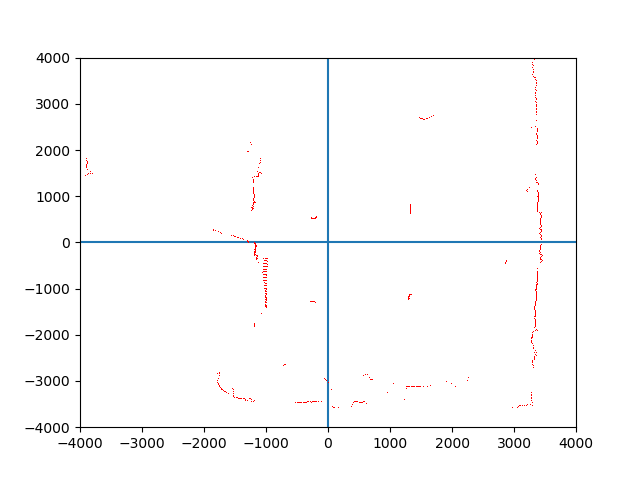

In [7]:
print(len(one_turn_measure))
%matplotlib notebook
one_turn_measure = outr.keep_good_measures(one_turn_measure[0], 30)
print(len(one_turn_measure))
chh.display_measures(one_turn_measure)

503


<IPython.core.display.Javascript object>


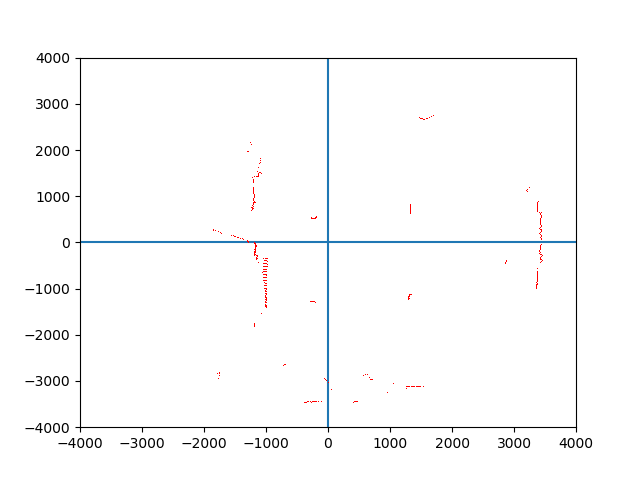

In [8]:
%matplotlib notebook
one_turn_measure = mm.remove_too_far_or_too_close(one_turn_measure)
print(len(one_turn_measure))
chh.display_measures(one_turn_measure)

In [9]:
cartesian_one_turn_measure = outr.one_turn_to_cartesian_points(one_turn_measure)
cartesian_one_turn_measure = [np.array(measure) for measure in cartesian_one_turn_measure]
clusters, means = clus.clusterize(cartesian_one_turn_measure)

<IPython.core.display.Javascript object>


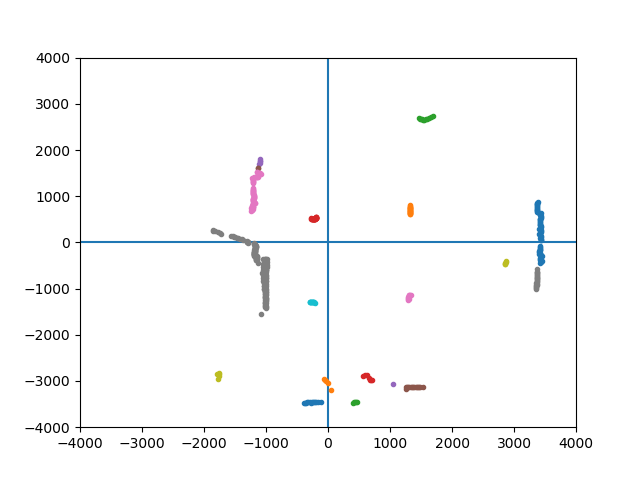

In [16]:
%matplotlib notebook
chc.plot_clustering(clusters)

In [11]:
real_clusters = []
circle_centers = []
for cluster in clusters:
    c = clus.Cluster()
    c.add_points(cluster)
    real_clusters.append(c)
for cluster in real_clusters:
    res = cluster.is_a_fix_beacon()
#     print(res.fun)
    if res.fun[0] < 100:
        print(res.fun)
        print(res.x)
        circle_centers.append(res.x)
        

[42.36964147  0.        ]
[-1187.07958045  1770.46659877]
[63.59767955  0.        ]
[-1086.20026526  1523.90583158]
[24.68956955  0.        ]
[ -280.76285767 -1382.18241965]
[1.823346e-11 0.000000e+00]
[ 1144.83252181 -3054.22805473]
[2.5691474 0.       ]
[2960.12662364 -454.19013508]


<IPython.core.display.Javascript object>


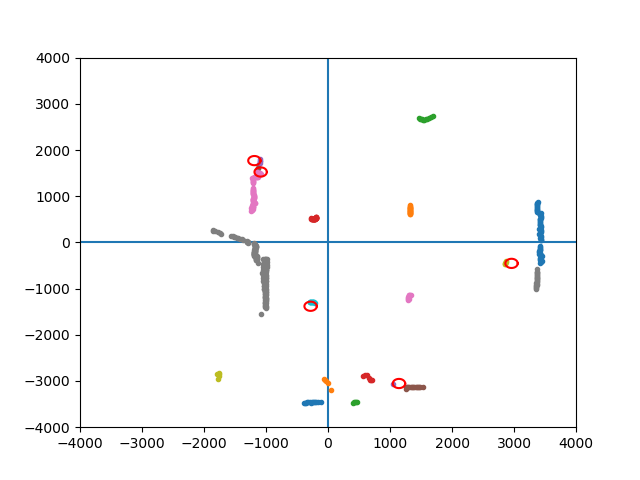

In [17]:
%matplotlib notebook
thetas = np.deg2rad(np.arange(0, 360, 1))
real_radius = 100


chc.plot_clustering(clusters, False)
for circle_center in circle_centers:
    xx = circle_center[0] + real_radius*np.cos(thetas)
    yy = circle_center[1] + real_radius*np.sin(thetas)
    pl.plot(xx, yy, "r-")
pl.show()

<IPython.core.display.Javascript object>


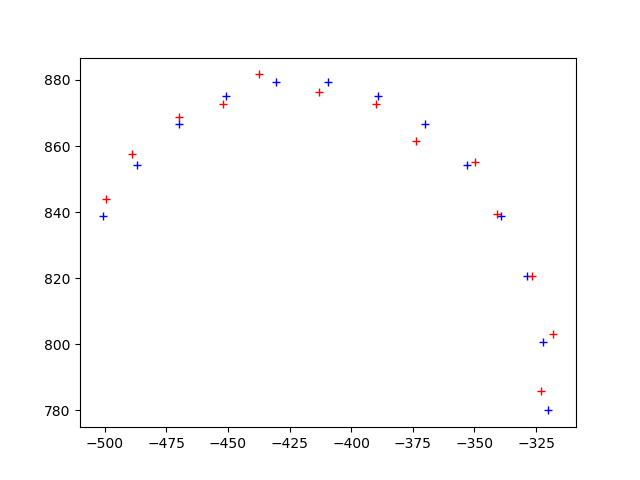

In [18]:
%matplotlib notebook
thetas = np.deg2rad(np.arange(0, 150, 12))
real_x, real_y = (-420, 780)
real_radius = 100
sigma = 3
xx_real = real_radius * np.cos(thetas) + real_x
xx_noisy = real_radius * np.cos(thetas) + real_x + np.random.randn(len(thetas))*sigma
yy_real = real_radius * np.sin(thetas) + real_y
yy_noisy = real_radius * np.sin(thetas) + real_y + np.random.randn(len(thetas))*sigma


pl.plot(xx_real, yy_real, 'b+')
pl.plot(xx_noisy, yy_noisy, 'r+')
pl.show()

In [14]:
%matplotlib notebook
sigma = 2
points = [np.array([xx_noisy[i], yy_noisy[i]])+np.random.randn(2)*sigma for i in range(len(xx_noisy))]
cluster = clus.Cluster()
cluster.add_points(points)
xy = cluster.is_a_circle(100)

<IPython.core.display.Javascript object>


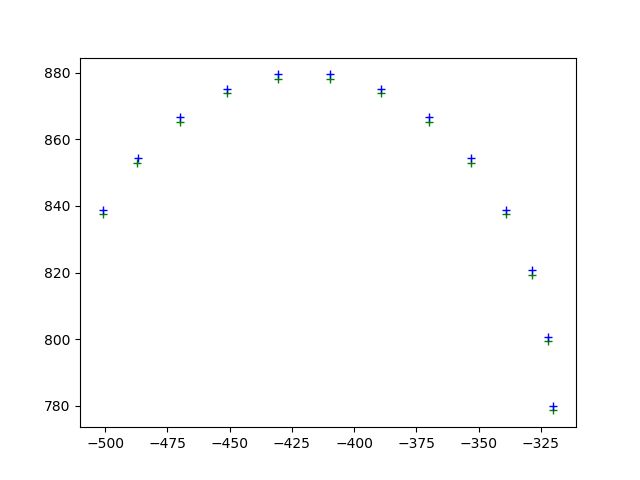

In [15]:

%matplotlib notebook
real_radius = 100

xx_reconstructed = real_radius * np.cos(thetas) + xy.x[0]
yy_reconstructed = real_radius * np.sin(thetas) + xy.x[1]

pl.plot(xx_reconstructed, yy_reconstructed, 'g+')
pl.plot(xx_real, yy_real, 'b+')
pl.show()